In [262]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, pad_sequences
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
import datetime
import kagglehub
from tqdm import tqdm

In [263]:
# Download latest version
path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

print("Path to dataset files:", path)
train_df = pd.read_csv(path+"/train.csv")
train_df["label"].unique()

Path to dataset files: /Users/mzitoh/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4


array(['Swing', 'SkyDiving', 'BreastStroke', 'TableTennisShot',
       'FloorGymnastics', 'Rowing', 'SoccerJuggling', 'BenchPress',
       'TennisSwing', 'FrisbeeCatch', 'Kayaking', 'ApplyLipstick',
       'RopeClimbing', 'JumpingJack', 'BlowingCandles', 'BabyCrawling',
       'HammerThrow', 'BoxingPunchingBag', 'Skiing', 'UnevenBars',
       'PullUps', 'RockClimbingIndoor', 'HeadMassage', 'HulaHoop',
       'Rafting', 'ShavingBeard', 'LongJump', 'FieldHockeyPenalty',
       'VolleyballSpiking', 'Punch', 'Archery', 'PlayingDhol',
       'CleanAndJerk', 'PlayingDaf', 'GolfSwing', 'PlayingSitar',
       'IceDancing', 'SkateBoarding', 'BodyWeightSquats',
       'HandstandPushups', 'BalanceBeam', 'WallPushups', 'HorseRiding',
       'Bowling', 'JumpRope', 'CuttingInKitchen', 'CliffDiving',
       'PlayingGuitar', 'FrontCrawl', 'HandstandWalking', 'Fencing',
       'Basketball', 'Typing', 'TaiChi', 'PlayingCello', 'Lunges',
       'Shotput', 'Nunchucks', 'ApplyEyeMakeup', 'BaseballPitch',
 

#Check all 10 classes to verify if data exists for each class

In [264]:
ucf10Classes=["Diving",
"GolfSwing",
"SoccerPenalty",
"BenchPress",
"HorseRiding",
"Biking",
"SkateBoarding",
"Swing",
"TennisSwing",
"HandstandWalking"]

for _class in ucf10Classes:
    print(_class,len(train_df[train_df['label']==_class]))


Diving 112
GolfSwing 104
SoccerPenalty 102
BenchPress 120
HorseRiding 123
Biking 100
SkateBoarding 90
Swing 98
TennisSwing 124
HandstandWalking 83


In [265]:
# from google.colab import drive
# drive.mount('/content/drive')

In [266]:
content = []

sample = 50

for _class in ucf10Classes:
  content.extend(train_df[train_df['label']==_class].sample(sample).values)


content = np.array(content)
len(content)
content[51]

array(['v_GolfSwing_g20_c05', '/train/GolfSwing/v_GolfSwing_g20_c05.avi',
       'GolfSwing'], dtype=object)

In [267]:
content[450]

array(['v_HandstandWalking_g16_c02',
       '/train/HandstandWalking/v_HandstandWalking_g16_c02.avi',
       'HandstandWalking'], dtype=object)

In [268]:
# content = content.reshape(500,)
x = content[:,1]
x_name = content[:,0]
y = content[:,2]
y[0],x[0], x_name[0], y[50], x[50]

('Diving',
 '/train/Diving/v_Diving_g04_c01.avi',
 'v_Diving_g04_c01',
 'GolfSwing',
 '/train/GolfSwing/v_GolfSwing_g13_c04.avi')

#Frame Reader

In [269]:
def read_frames(root_folder,arr,each_nth=10):
    videos=[]
    for _content  in tqdm(arr):
        clear_output()
        vcap=cv2.VideoCapture(f"{root_folder}/{_content}")
        success=True
        frames=[]
        cnt=0
        while success:
            try:
              success,image=vcap.read()
              cnt+=1
              if cnt%each_nth==0:
                image=resize(image,(128,192))
                # imshow(image)
                frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)
    return videos

In [270]:
X_frames = read_frames(path,x)

100%|██████████| 500/500 [00:52<00:00,  9.52it/s]


In [ ]:
X_padded_frames = pad_sequences(X_frames, maxlen=30, dtype='float32', padding='post', truncating='post', value=0.0)

In [314]:
# Create a StringLookup layer
lookup = tf.keras.layers.StringLookup(vocabulary=ucf10Classes, num_oov_indices=0, output_mode="one_hot")
y_np = lookup(y).numpy()

In [315]:
x_train, x_test, y_train , y_test = train_test_split(X_padded_frames, y_np, shuffle=True,test_size = 0.2,random_state = 42)

30


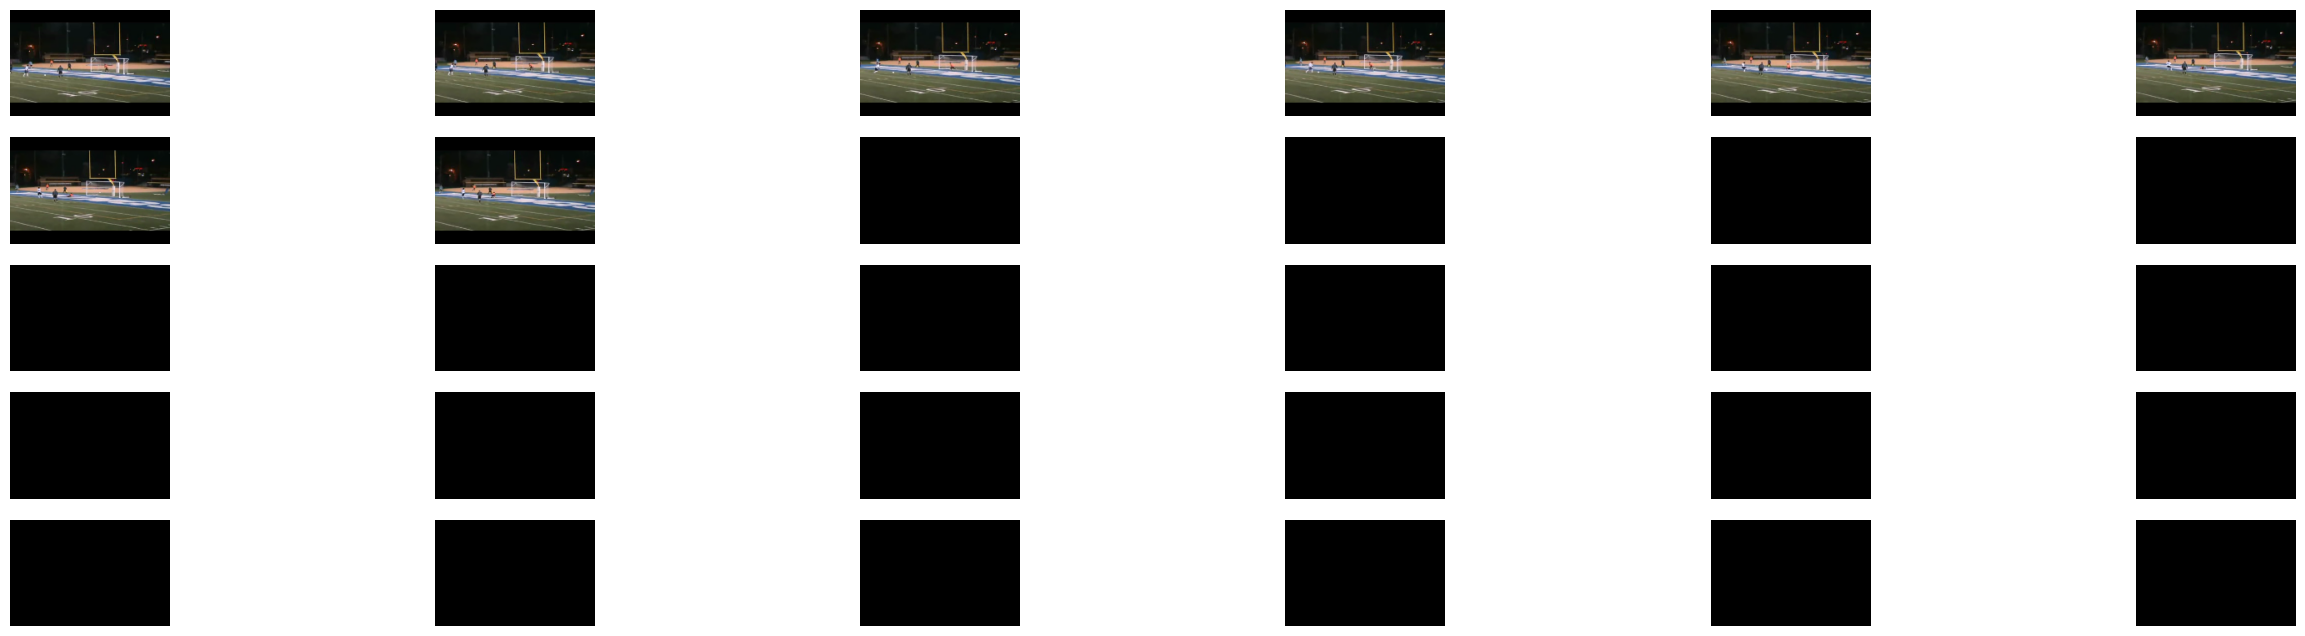

In [316]:
fig = plt.figure(figsize=(32,8))

random_video_index = np.random.randint(0, len(X_padded_frames))

print(len(X_padded_frames[random_video_index]))

for i, image in enumerate(X_padded_frames[random_video_index]):
    ax = plt.subplot(5, 6, i+1)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.axis('off')

plt.show()

In [317]:
def list_to_stack(xs):
  xs=tf.stack(xs, axis=1)
  s = tf.shape(xs)

  return xs

In [318]:
ish=(30, 128, 192, 3)
target_shape=(10,32*48*50)

xs=[]


inp = Input(ish)

for slice_indx in range(0,10,1):
  x=Lambda(lambda x: x[:, slice_indx])(inp)
  x=BatchNormalization(momentum=0.8)(x)
  x=Conv2D(filters=20, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)

  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)

  xs.append(x)


t=Lambda(list_to_stack)(xs)
t=Conv3D(50,3,padding='same')(t)
t=BatchNormalization(momentum=0.8)(t)
t=Reshape(target_shape)(t)
t=GRU(25, return_sequences=True)(t)
t=GRU(50, return_sequences=False,dropout=0.5)(t)

t=Dense(100,'relu')(t)
out=Dense(10, activation='softmax')(t)

model = Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.SGD(learning_rate=0.0087)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 30, 128,   │          0 │ -                 │
│ (InputLayer)        │ 192, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_110 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_111 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_112 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_113 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_114 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_115 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_116 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_117 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_118 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_119 (Lambda) │ (None, 128, 192,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_110[0][0]  │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_111[0][0]  │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_112[0][0]  │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_113[0][0]  │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_114[0][0]  │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 192,  │         12 │ lambda_115[0][0]

 Total params: 5,963,755 (22.75 MB)

 Trainable params: 5,962,595 (22.75 MB)

 Non-trainable params: 1,160 (4.53 KB)

In [319]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [320]:
weights_file_path = "rnn_b.weights.h5"

checkpoint = ModelCheckpoint(
    weights_file_path,
    monitor="val_loss",
    mode="min",  # Save the model when the loss decreases (when model improves)
    save_weights_only=True,
    save_best_only=True,
    verbose=1,
)

In [321]:
EPOCHS = 100

In [322]:
history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=10,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[checkpoint],
)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1568 - loss: 2.2142
Epoch 1: val_loss improved from inf to 2.07075, saving model to rnn_b.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.1576 - loss: 2.2138 - val_accuracy: 0.3500 - val_loss: 2.0708
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2900 - loss: 2.0806
Epoch 2: val_loss improved from 2.07075 to 1.98463, saving model to rnn_b.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2906 - loss: 2.0798 - val_accuracy: 0.3800 - val_loss: 1.9846
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4638 - loss: 1.9195
Epoch 3: val_loss improved from 1.98463 to 1.91798, saving model to rnn_b.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4634 - loss: 1.9196 - val_accuracy: 0.4000 - val_loss: 1.9180
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5454 - loss: 1.7833
Epoch 4: val_loss improved from 1.91798 to 1.84942, saving model to 

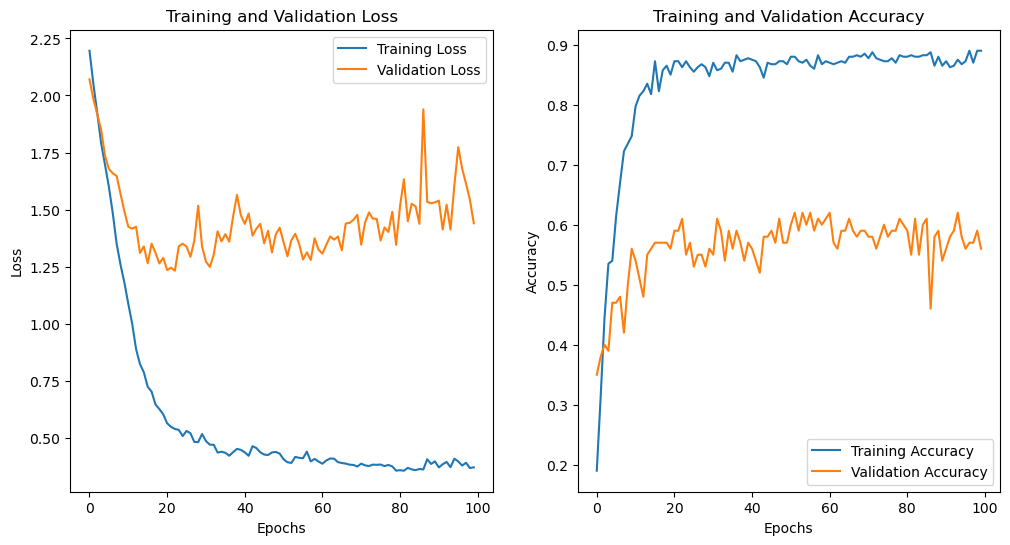

In [336]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
plt.close()

In [340]:
# fig = plt.figure(figsize=(14,6))

# ax = plt.subplot(1,2,1)
# plt.plot(history.history['loss'], label='Training loss')
# ax.legend(loc="upper left")
# plt.ylabel('Loss')
# plt.xlabel('No. epoch')
# ax = plt.subplot(1,2,2)
# plt.plot(history.history['val_loss'], label='Vallidation loss')
# ax.legend(loc="upper left")
# fig.suptitle('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('No. epoch')
# plt.show()

In [342]:
# fig = plt.figure(figsize=(14,6))

# ax = plt.subplot(1,2,1)
# plt.plot(history.history['accuracy'], label='Training accuracy')
# ax.legend(loc="upper left")
# plt.ylabel('Accuracy')
# plt.xlabel('No. epoch')
# ax = plt.subplot(1,2,2)
# plt.plot(history.history['val_accuracy'], label='Vallidation accuracy')
# ax.legend(loc="upper left")
# fig.suptitle('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('No. epoch')
# plt.show()

In [325]:
classes = {content[i][1].split("/")[2] for i in range(len(content))}
class_map = dict(enumerate(classes))
class_map

{0: 'SkateBoarding',
 1: 'HorseRiding',
 2: 'HandstandWalking',
 3: 'BenchPress',
 4: 'GolfSwing',
 5: 'Swing',
 6: 'TennisSwing',
 7: 'SoccerPenalty',
 8: 'Diving',
 9: 'Biking'}

In [326]:
random_videos = np.random.randint(0, len(x_test), size=(100))

predicted = model.predict(x_test[random_videos], batch_size=32)
predicted = np.argmax(predicted, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step


ValueError: num must be an integer with 1 <= num <= 10, not 11

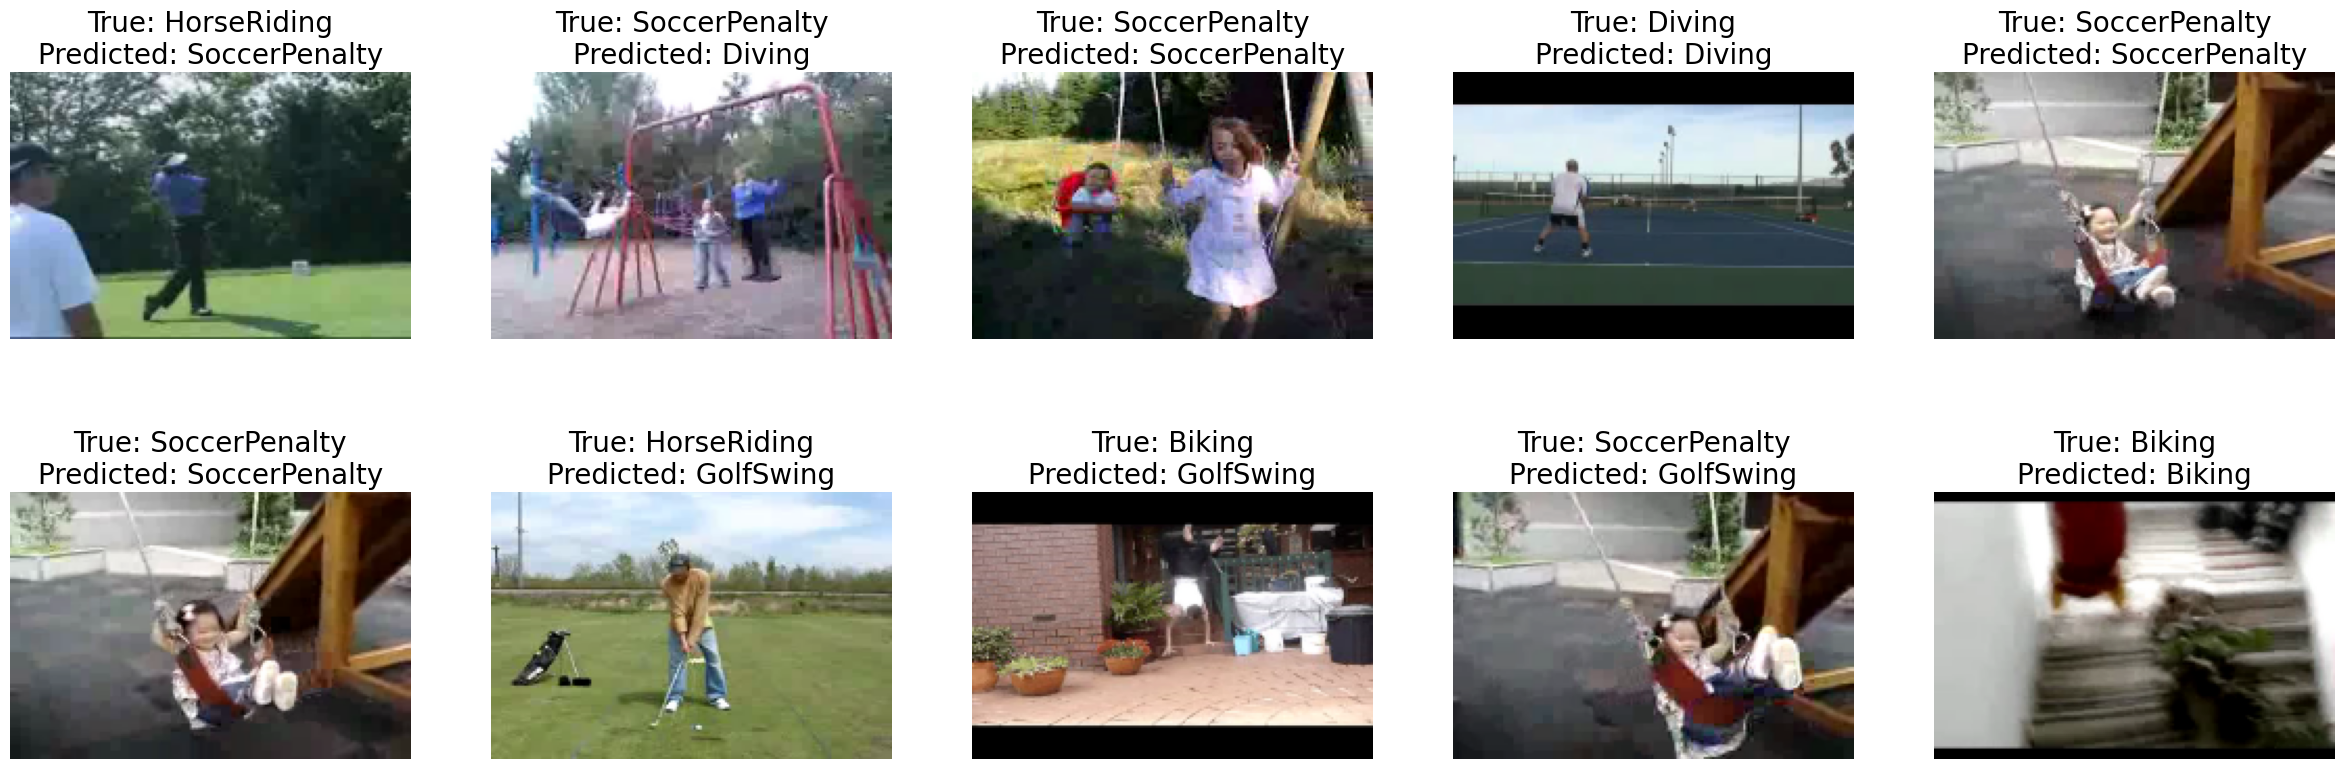

In [343]:
fig = plt.figure(figsize=(30,10))

true_labels = []
pred_labels = []

for i, rand_indx in enumerate(random_videos):
    ax = plt.subplot(2, 5, i+1)
    video = x_test[rand_indx]
    frame = video[np.random.randint(0, 10)]

    # Ensure the frame is in uint8 format
    if frame.dtype != np.uint8:
        frame = (frame * 255).astype(np.uint8)

    # Convert the frame to RGB (if it's in BGR format)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # true_label = y_test[rand_indx][0] # Single-element array
    true_label = np.argmax(y_test[rand_indx]) # One-hot encoded array
    true_class = class_map[int(true_label)]  # Ensure scalar integer index
    true_labels.append(true_label)

    predicted_class = class_map[predicted[i]]
    pred_labels.append(predicted[i])

    # Set the title with true and predicted classes
    ax.set_title(f"True: {true_class}\nPredicted: {predicted_class}", fontsize=20)
    plt.imshow(rgb_frame)
    plt.axis('off')  # Remove axis for cleaner display

plt.show()

In [ ]:
true_labels

[0, 2, 4, 7, 1, 1, 6, 6, 1, 1]

In [ ]:
pred_labels

[0, 2, 4, 3, 4, 4, 6, 4, 2, 1]

In [ ]:
list(class_map.values())

['SkateBoarding',
 'HorseRiding',
 'HandstandWalking',
 'BenchPress',
 'GolfSwing',
 'Swing',
 'TennisSwing',
 'SoccerPenalty',
 'Diving',
 'Biking']

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels, zero_division=0, target_names=list(class_map.values()))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.25      0.40         4
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         0
           4       0.25      1.00      0.40         1
           6       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1

    accuracy                           0.50        10
   macro avg       0.54      0.54      0.45        10
weighted avg       0.78      0.50      0.50        10

